In [1]:
import pandas as pd

In [2]:
df = pd.read_csv('../dataset/complete_dataset.csv')
df.drop_duplicates(subset=['IMDB_ID'], inplace=True)
df.dropna(subset=['text', 'year'], inplace=True)

/Users/lennartkeller/opt/anaconda3/envs/clustering/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3062: DtypeWarning: Columns (0,1,3,5,6,7,8,9,16) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
df = df[~df.text.apply(lambda x: len(x) < 500)]

In [275]:
import re
df['text_length'] = df.text.apply(lambda x: len(re.findall(r'\w+', x)))

In [318]:
import re
remove_subcentral_annotation = re.compile(r'übersetzt von.+$', flags=re.I)
remove_season_episode_annotation = re.compile(r's\d+?e\d+?', flags=re.I)
remove_remove_season_episode_annotation_german = re.compile(r'staffel.+?episode', flags=re.I)
remove_remove_season_episode_annotation_german_2 = re.compile(r'staffel.+?folge', flags=re.I)
remove_subcentral_note = re.compile(r'subcentral.+ präsentiert', flags=re.I)
remove_subtitle_statement = re.compile(r'Untertitel von.+$', flags=re.I)
remove_netflix_original_statement = re.compile(r'EINE NETFLIX ORIGINAL SERIE', flags=re.I)
remove_tvuser = re.compile(r'tv4user.+?präsentiert', flags=re.I)
remove_tvuser_subcentral = re.compile(r'subcentral.+?tv4user', flags=re.I)
remove_subcentral_url = re.compile(r'subcentral\.de', flags=re.I)
remove_tv4user_url = re.compile(r'tv4user\.de', flags=re.I)
remove_sub_statement = re.compile(r'subbed\w+?by', flags=re.I)
remove_tiger_statement = re.compile(r'übersetzung filmtiger', flags=re.I)

for regex in (remove_subcentral_annotation,
              remove_season_episode_annotation,
              remove_remove_season_episode_annotation_german,
              remove_remove_season_episode_annotation_german_2,
              remove_subcentral_note,
              remove_subtitle_statement,
              remove_netflix_original_statement,
              remove_tvuser,
              remove_tvuser_subcentral,
              remove_subcentral_url,
              remove_tv4user_url,
              remove_sub_statement,
              remove_tiger_statement):
    
    df.text = df.text.str.replace(regex, '')

In [278]:
from pathlib import Path
import numpy as np
def read_embeddings(embedding_file: str):
    data = Path(embedding_file).read_text()
    lines = data.split('\n')
    filenames = []
    embeddings = []
    for line in lines:
        line_data = line.split(' ')
        if len(line_data) >=2 :
            filenames.append(line_data[0])
            embeddings.append(list(map(float, line_data[1:])))
    return np.asarray(filenames), np.asarray(embeddings)

In [279]:
filenames, embeddings = read_embeddings('../dataset/embeddings_mean.txt')

In [280]:
df.filename

107      6094543.xml
109      3653850.xml
110      6581015.xml
111      6564964.xml
112      4711374.xml
            ...     
61410    7057767.xml
61411    7057760.xml
61413    7057765.xml
61414    7057793.xml
61415    7063882.xml
Name: filename, Length: 34310, dtype: object

In [281]:
df.head()

,filename,text,IMDB_ID,genre,year,production_region,corpus,duration,directors,writers,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,averageRating,numVotes,text_length
107,6094543.xml,"Zuvor bei "" The Blacklist "" ... - Willst du de...",tt3276470,"Crime,Drama,Mystery",1191.0,NaN,untokenisiert,43,nm0250267,"nm0092578,nm0071299",tvEpisode,The Pavlovich Brothers (Nos. 119-122),The Pavlovich Brothers (Nos. 119-122),0.0,2014.0,NaN,43,8.6,1732.0,706
109,3653850.xml,[ Subtitles by Subturtles ] Du sollst nach Hau...,tt1175,"Drama,Romance",1912.0,French,untokenisiert,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4995
110,6581015.xml,HINTER DER LEIWAND Die Anwendung für die Arbei...,tt6414,"Comedy,Romance,Short",1916.0,English,untokenisiert,30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,125
111,6564964.xml,DER GRAF Maße : Hals 30 cm - Ohr - 4 cm Mounth...,tt6548,"Comedy,Short",1916.0,English,untokenisiert,24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,85
112,4711374.xml,DER TODESKUSS Kriminaldrama in drei Akten Kame...,tt6617,"Comedy,Crime,Drama",1916.0,NaN,untokenisiert,60,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,642


In [319]:
movies = df[(df.titleType == 'movie') | (df.titleType == 'tvEpisode')].copy().sample(frac=0.5)

In [320]:
movies.shape

(8483, 20)

In [321]:
movies.groupby('titleType').describe()['text_length']

,count,mean,std,min,25%,50%,75%,max
titleType,,,,,,,,
movie,1841.0,6044.779468,2870.509119,0.0,4291.00,5828.0,7469.0,47161.0
tvEpisode,6642.0,3000.967179,1919.597482,0.0,1222.25,3184.5,4364.0,14016.0


In [322]:
from sklearn.feature_extraction.text import TfidfVectorizer
from stop_words import get_stop_words

tfidf = TfidfVectorizer(max_features=5000, ngram_range=(2, 4), stop_words=get_stop_words('de'))

X = tfidf.fit_transform(movies.text)

In [323]:
from sklearn.decomposition import PCA
from umap import UMAP

reducer = PCA(n_components=2)

Xr = reducer.fit_transform(X.todense())

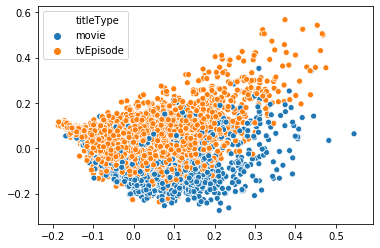

In [324]:
import seaborn as sns

sns.scatterplot(x=Xr[:,0], y=Xr[:,1], hue=movies.titleType)

In [332]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from scipy.sparse import hstack

X_train, X_test, y_train, y_test = train_test_split(Xp, movies.titleType, test_size=.2)
clf = LogisticRegression()

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred))

ValueError: blocks[0,:] has incompatible row dimensions. Got blocks[0,1].shape[0] == 1, expected 8483.

In [326]:
top_feat_movie = np.argpartition(clf.coef_.ravel(), 20)[:20]
top_feat_tvmovie = np.argpartition(clf.coef_.ravel(), -20)[-20:]

In [327]:
for tf in top_feat_movie:
    print(dict(zip(tfidf.vocabulary_.values(), tfidf.vocabulary_.keys())).get(tf), tf, sep=' => ')

tut weh => 4247
verrückt geworden => 4300
vereinigten staaten => 4288
sag mal => 3604
guten tag => 1354
halt maul => 1406
jahre später => 2103
guten abend => 1345
komm her => 2240
ersten mal => 626
ganz ruhig => 782
los los => 2588
kung fu => 2361
gute nacht => 1336
na los => 2999
hau ab => 1553
mach schon => 2634
ja herr => 1914
papa papa => 3477
ja gut => 1901


In [328]:
for tf in top_feat_tvmovie:
    print(dict(zip(tfidf.vocabulary_.values(), tfidf.vocabulary_.keys())).get(tf), tf, sep=' => ')

weißt schon => 4614
mr thompson => 2902
ex frau => 639
wahrheit sagen => 4406
sieht hätte => 4009
paar fragen => 3460
mm hmm => 2878
oh hey => 3307
oh gut => 3302
getan hast => 1084
wissen lassen => 4767
tschüs tschüs => 4158
ziemlich gut => 4936
hattest recht => 1551
00 uhr => 0
heute morgen => 1619
gestern abend => 1080
german sdh => 1035
bisher geschah => 213
übersetzung filmtiger => 4999
